In [1]:
# Standard library imports
import random

# Third-party imports
import torch
from torch import Tensor, nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from tqdm.notebook import tqdm_notebook as tqdm

import gym_agent as ga

# Local imports
import utils

In [2]:
gym.register(
    id="ModifiedCarRacing-v0",
    entry_point="CarRacing.car_racing:ModifiedCarRacing",
    reward_threshold=900,
)

In [3]:
n_games, max_t = 500, 1000
chkpt_dir = 'checkpoints/'

env_id = 'ModifiedCarRacing-v0'

seed = 110404

die_if_grass = True

In [4]:
class DeepQNetwork(nn.Module):
    def __init__(self, n_inp: int, features: list[int], n_actions: int):
        super().__init__()

        # Create a list of layer sizes including input, hidden, and output layers
        layer_sizes = [n_inp] + features + [n_actions]

        # Initialize an empty sequential container
        self.net = nn.Sequential()

        # Loop through the layer sizes to create the network
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.net.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            
            # Add ReLU activation function for all layers except the last one
            if i != len(layer_sizes) - 2:
                self.net.append(nn.ReLU(inplace=True))

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        # Pass the input state through the network
        return self.net(state)

In [5]:
class DQN_CAR(ga.AgentBase):
    def __init__(
            self,
            gamma: float,
            lr: float,
            state_shape: int,
            action_shape: int,
            action_space: int,
            batch_size: int,
            update_every: int,
            eps_start: float = 1.0,
            eps_decay: float = 0.995,
            eps_end: float = 0.01,
            buffer_size: int = 100000,
            device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
            seed: int = 0,
    ) -> None:
        super().__init__(state_shape, action_shape, batch_size, False, update_every, buffer_size, device, seed)

        self.gamma = gamma
        self.action_space = action_space
        self.update_every = update_every
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_end = eps_end
        self.device = device
        self.seed = seed

        # Soft update parameter
        self.tau = 1e-3

        # Local model for action value estimation
        self.local_model = DeepQNetwork(n_inp=state_shape[0], features=[256, 256], n_actions=len(action_space)).to(device)
        # Target model for action value estimation
        self.target_model = DeepQNetwork(n_inp=state_shape[0], features=[256, 256], n_actions=len(action_space)).to(device)
        # Optimizer for the local model
        self.optimizer = optim.Adam(self.local_model.parameters(), lr)

        # Initialize time step for updating every 'update_every' steps
        self.time_step = 0
        # Initialize epsilon for epsilon-greedy policy
        self.eps = eps_start

    def reset(self):
        self.eps = max(self.eps_end, self.eps_decay * self.eps)

    @torch.no_grad()
    def act(self, state: np.ndarray) -> int:
        # Determine epsilon value based on evaluation mode
        if self.eval:
            eps = 0
        else:
            eps = self.eps

        # Epsilon-greedy action selection
        if random.random() >= eps:
            # Convert state to tensor and move to the appropriate device
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)

            # Set local model to evaluation mode
            self.local_model.eval()
            # Get action values from the local model
            action_value = self.local_model(state)
            # Set local model back to training mode
            self.local_model.train()

            # Return the action with the highest value
            return np.argmax(action_value.cpu().data.numpy())
        else:
            # Return a random action from the action space
            return random.choice(self.action_space)

    def learn(self, states: Tensor, actions: Tensor, rewards: Tensor, next_states: Tensor, terminals: Tensor):
        # Get the maximum predicted Q values for the next states from the target model
        q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute the Q targets for the current states
        q_targets = rewards + (self.gamma * q_targets_next * (~terminals))

        # Get the expected Q values from the local model
        q_expected = self.local_model(states).gather(1, actions.long())

        # Compute the loss
        loss = F.mse_loss(q_expected, q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update the target network
        self.soft_update()

    def soft_update(self):
        for target_param, local_param in zip(self.target_model.parameters(), self.local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

### Transform

In [6]:
class StateTfm(ga.Transform):
    def __init__(self):
        super().__init__()
        # self.observation_space = gym.spaces.Dict({
        #     'state': gym.spaces.Box(low=0, high=1, shape=(1, 96, 96), dtype=np.float32),
        #     'additional_info': gym.spaces.Box(low=0, high=np.inf, shape=(14,), dtype=np.float32),
        # })

        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(14,), dtype=np.float32)

    def __call__(self, observation) -> np.ndarray:
        rays = observation['rays']
        vels = observation['vels']

        res = np.concatenate([rays, vels])
        return res

In [7]:
class RewardTfm(ga.Transform):
    def __init__(self, time_penalty_min: float = 1e-5, time_penalty_max: float = 0.2, time_increment: float = 1.01):
        super().__init__()
        self.t = 0
        self.eps = 1.0
        self.time_penalty_max = time_penalty_max
        self.time_penalty_min = time_penalty_min
        self.time_increment = time_increment
        self.time_penalty = time_penalty_min

    
    def __call__(self, observation, reward):
        # Increment time step and apply time penalty to the reward
        self.t += 1
        return reward - self.time_penalty * self.t
    
    def reset(self):
        self.t = 0
        self.time_penalty *= self.time_increment
        if self.time_penalty > self.time_penalty_max:
            self.time_penalty = self.time_penalty_max

### train

In [8]:
env = ga.make('ModifiedCarRacing-v0', continuous=False, die_if_grass = die_if_grass)

In [9]:
env.set_observation_transform(StateTfm())
# env.set_reward_transform(RewardTfm())

In [10]:
agent = DQN_CAR(
    gamma=0.99,
    lr=5e-4,
    state_shape=env.observation_space.shape,
    action_shape=(1, ),
    action_space=range(env.action_space.n),
    batch_size=64,
    update_every=4,
    eps_start=1.0,
    eps_decay=0.995,
    eps_end=0.01,
    buffer_size=100000,
    device='cuda',
    seed=seed,
)

In [12]:
scores = agent.fit(env, 1000, 1000, True, False, chkpt_dir, tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

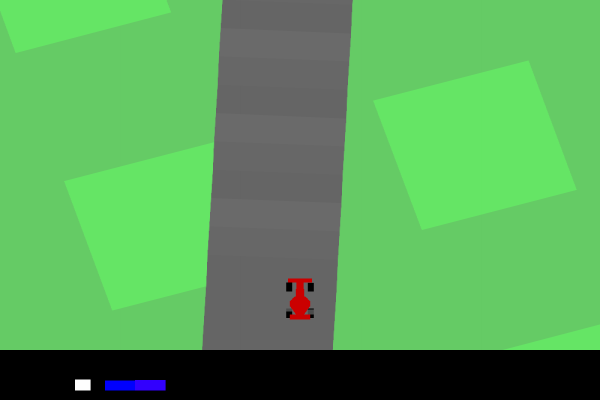

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/fool/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_36126/3700223540.py", line 6, in <module>
    agent.play_jupyter(env, stop_if_truncated=True)
  File "/home/fool/Documents/code/Project/DL/Project/gym_agent/agent/agent_base.py", line 299, in play_jupyter
    env.render()
  File "/home/fool/anaconda3/envs/PyTorchRL/lib/python3.11/site-packages/gymnasium/core.py", line 471, in render
    return self.env.render()
           ^^^^^^^^^^^^^^^^^
  File "/home/fool/anaconda3/envs/PyTorchRL/lib/python3.11/site-packages/gymnasium/wrappers/order_enforcing.py", line 70, in render
    return self.env.render(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fool/anaconda3/envs/PyTorchRL/lib/python3.11/site-packages/gymnasium/wrappers/env_checker.py", line 67, in render
    return self.env.render(*args, 

In [11]:
env = ga.make('ModifiedCarRacing-v0', render_mode = 'rgb_array', continuous=False, die_if_grass = False, lap_complete_percent = 1)
env.set_observation_transform(StateTfm())
# env.set_reward_transform(RewardTfm())

agent.load('checkpoints')
agent.play_jupyter(env, stop_if_truncated=True)

275.5